In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')

import numpy as np
import pandas as pd

In [2]:
from spykes.neurovis import NeuroVis

# Reproduce a figure from a published article with a public dataset

### This article:
 Nuo Li, Tsai-Wen Chen, Zengcai V. Guo, Charles R. Gerfen & Karel Svoboda.   A motor cortex circuit for motor planning and movement.  Nature 519, 51–56 (05 March 2015) PMID: 25731172 doi: 10.1038/nature14178 [[link to paper](http://www.nature.com/nature/journal/v519/n7541/full/nature14178.html)]

### Has a publicly available dataset on CRCNS.org:
 Nuo Li, Charles R Gerfen, Karel Svoboda (2014); Extracellular recordings from anterior lateral motor cortex (ALM) neurons of adult mice performing a tactile decision behavior. CRCNS.org [[link to dataset](https://crcns.org/data-sets/motor-cortex/alm-1)]


### Here's Figure 2:

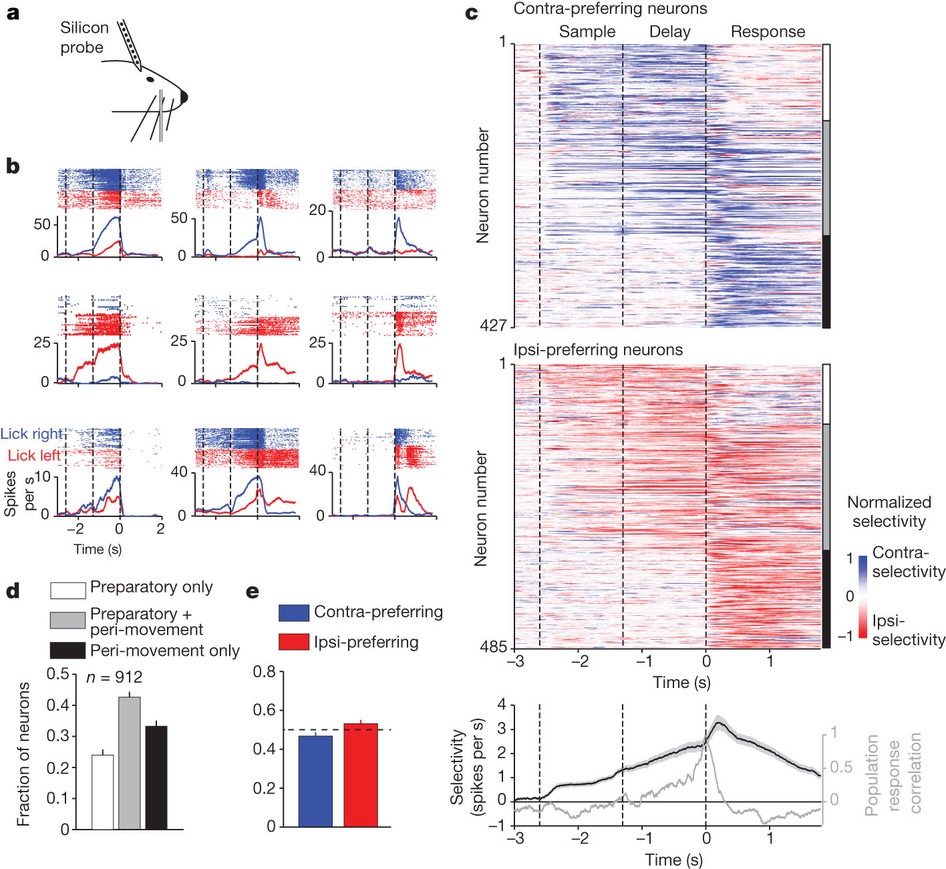

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(filename="./figures/nature14178-f2.jpg", width=650)

# Let's reproduce the first panel of Figure 2b

#### We will need the data for neuron `9` of session `ANM218457_20131006`

## 0. Download data

#### 0.1. Register in `CRCNS` [[link to request account](https://crcns.org/request-account)]
#### 0.2. Download file `data_structure_ANM218457.tar.gz` [[link](https://portal.nersc.gov/project/crcns/download/alm-1/datafiles/data_structure_files)]
#### 0.3. Unzip it and you will find file `data_structure_ANM218457_20131006.mat`

## 1. Load data

In [4]:
import scipy.io
mat = scipy.io.loadmat('data_structure_ANM218457_20131006')

## 2. Get spike times

In [5]:
neuron_n = 9
spike_times = mat['obj']['eventSeriesHash'][0][0]['value'][0][0][0][neuron_n-1][0][0][1]
spike_times = [i[0] for i in spike_times]

# instantiate neuron
neuron = NeuroVis(spike_times, neuron_n)
print 'neuron %d has a firing rate of %0.2f spikes per second' % (neuron_n, neuron.firingrate)

neuron 9 has a firing rate of 5.07 spikes per second


Let's use all the goodness of `pandas` to define all our conditions. Here, we will create a set of extra columns in the data frame that are going to be useful to select and plot PSTHs for specific conditions. We aim to follow the principles outlined in [Hadley Wickam's white paper on Tidy Data](http://vita.had.co.nz/papers/tidy-data.pdf).

## 3. Get event times

In [6]:
data_df = pd.DataFrame()
data_df['trialStart'] = mat['obj']['trialStartTimes'][0][0][0]
data_df['cueTimes'] = np.squeeze(mat['obj']['trialPropertiesHash'][0][0][0][0][2][0][2])
data_df['RealCueTimes'] = data_df['trialStart'] + data_df['cueTimes']

# Collect all the events and display them
events = ['trialStart', 'cueTimes', 'RealCueTimes']
data_df[events].head()

,trialStart,cueTimes,RealCueTimes
0,2.261389,0.000000,2.261389
1,437.238815,5.784644,443.023459
2,448.597437,3.172654,451.770091
3,457.379402,7.776468,465.155870
4,470.885681,3.322320,474.208001


## 4. Get features

In [7]:
trialTypeMat = mat['obj']['trialTypeMat'][0][0].astype(np.bool_)
trialTypeStr = np.squeeze(np.stack(np.squeeze(mat['obj']['trialTypeStr'][0][0])))

for ind, feat in enumerate(trialTypeStr):
    data_df[str(feat)] = trialTypeMat[ind]

data_df['GoodTrials'] = np.squeeze(mat['obj']['trialPropertiesHash'][0][0][0][0][2][0][3]).astype(np.bool_)

# Collect all features and display them
features = ['HitR', 'HitL', 'ErrR', 'ErrL', 'NoLickR', 'NoLickL', 'LickEarly', 'StimTrials', 'GoodTrials']
data_df[features].head()

,HitR,HitL,ErrR,ErrL,NoLickR,NoLickL,LickEarly,StimTrials,GoodTrials
0,False,False,False,False,False,False,False,False,True
1,True,False,False,False,False,False,True,True,True
2,True,False,False,False,False,False,False,True,True
3,True,False,False,False,False,False,True,True,True
4,False,False,False,True,False,False,True,True,True


## 5. Define some tidy features


In [8]:
features_of_interst = ['HitR','HitL', 'ErrR', 'ErrL']

data_df['response'] = data_df[features_of_interst].apply(lambda row: row.argmax() if row.max()==True else '',axis=1)
data_df['correct'] = data_df['response'].map(lambda s: {'Hit':True,'Err':False,'':np.nan}[s[:3]])
data_df['response'] = data_df['response'].map(lambda s: {'L':'Lick left','R':'Lick right','':''}[s[-1:]])

data_df[['HitR','HitL', 'ErrR', 'ErrL','correct','response']].head()

,HitR,HitL,ErrR,ErrL,correct,response
0,False,False,False,False,NaN,
1,True,False,False,False,True,Lick right
2,True,False,False,False,True,Lick right
3,True,False,False,False,True,Lick right
4,False,False,False,True,False,Lick left


Let's put the events and the augmented features into a new data frame which we will use everywhere below.

In [9]:
# isolate trials of interest
trials_df = data_df[(
                    (data_df['GoodTrials']==True) &
                    (data_df['correct']==True)
                    )]

 ## 6. Plot PSTH and Raster plots

#### Rasters

None
descend


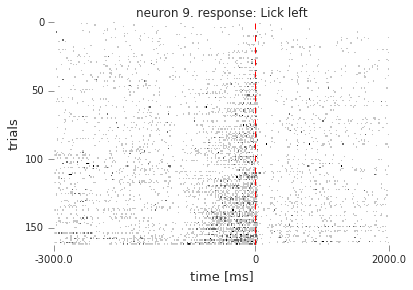

None
descend


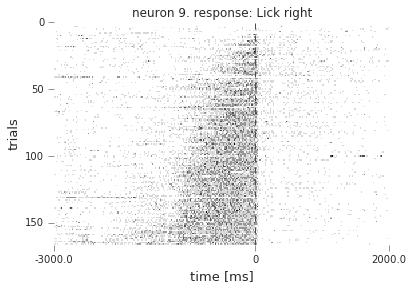

In [10]:
event = 'RealCueTimes'
conditions='response'
window = [-3000,2000]

rasters_fig2b1 = neuron.get_raster(event=event,
                                   conditions=conditions,
                                   df=trials_df,
                                   window=window,
                                   binsize=20,
                                   sortby='rate',
                                   sortorder='ascend');

#### PSTH

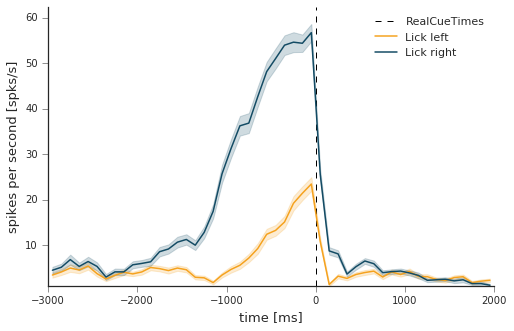

In [11]:
plt.figure(figsize=(8,5))
neuron.get_psth(event=event,
                df=trials_df,
                conditions=conditions,
                window=window,
                binsize=100);
plt.title('')
plt.show()

#### Reproduce Figure

None
descend
None
descend


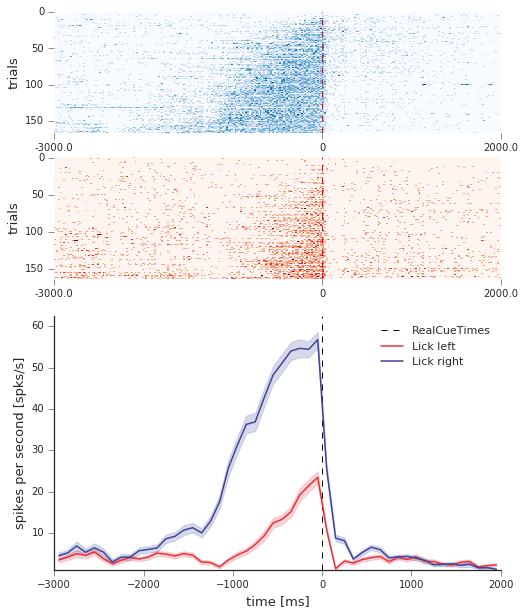

In [12]:
plt.style.use('seaborn-ticks')

cmap = [plt.get_cmap('Blues'), plt.get_cmap('Reds')]
colors = ['#E82F3A', '#3B439A']


#get rasters------------------------------------------------------
rasters_fig2b1 = neuron.get_raster(event=event,
                                   conditions=conditions,
                                   df=trials_df,
                                   window=window,
                                   binsize=20,
                                   plot=False);



plt.figure(figsize=(8,10))
cond_ids = rasters_fig2b1['data'].keys()[::-1]

#plot rasters-------------------------------------------------------
for i, cond_id in enumerate(cond_ids):
    plt.subplot(4,1,i+1)
    neuron.plot_raster(rasters=rasters_fig2b1,
                       cond_id=cond_id,
                       cmap=cmap[i],
                       sortby=None,
                       has_title=False)
    plt.xlabel('')
    
    
#plot psth-------------------------------------------------------    
plt.subplot(212)
psth = neuron.get_psth(event=event,
                conditions=conditions,
                df=trials_df,
                window=window,
                binsize=100,
                plot=True,
                colors=colors);
plt.title('')
plt.show()

#### ggplot

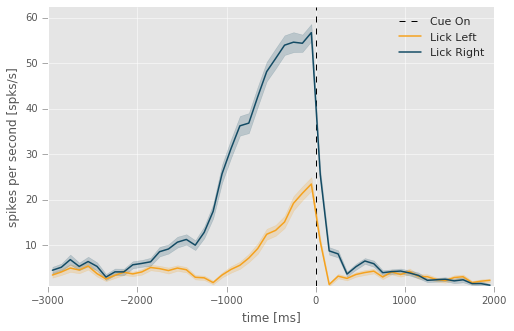

In [13]:
plt.style.use('ggplot')

plt.figure(figsize=(8,5))
neuron.get_psth(event=event,
                conditions=conditions,
                df=trials_df,
                event_name='Cue On',
                window=window,
                conditions_names=['Lick Left', 'Lick Right'],
                binsize=100);
plt.title('')
plt.show()